In [1]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
# Allow matplotlib to plot inside this notebook
%matplotlib inline
# Set the seed of the numpy random number generator so that the tutorial is reproducable
np.random.seed(seed=1)

http://www.cs.ubc.ca/~nando/540-2013/lectures.html
https://www.youtube.com/watch?v=w2OtwL5T1ow&list=PLE6Wd9FR--EdyJ5lbFl8UuGjecvVw66F6
http://videolectures.net/gpip06_mackay_gpb/
http://www.robots.ox.ac.uk/~mebden/reports/GPtutorial.pdf
http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

$X$ is samples

Mean is the expected value over all samples.

$$\overline{X} = \mathbb{E}[X]$$

Covariance:
https://en.wikipedia.org/wiki/Covariance


$$C(X,Y) = \mathbb{E}[(X-\overline{X})(Y-\overline{Y})^T] = \Sigma_{X,Y} $$

$$C(X,X) = \Sigma_{X}$$

Mean and Variance of a Linear Transformation

$Y = LX + u$ has mean $\overline{Y} = v + L\overline{X}$ and covariance matrix $\Sigma_{Y} = L\Sigma_{X}L^T$

Proof:

$$\overline{Y} = \mathbb{E}[Y] = \mathbb{E}[LX + u] = \mathbb{E}[LX] + u = L\overline{X} + u$$

$$\begin{split}
\Sigma_{Y} & = \mathbb{E}[(Y-\overline{Y})(Y-\overline{Y})^T] \\
           & = \mathbb{E}[(LX+u - L\overline{X}-u)(LX+u - L\overline{X}-u)^T] \\
           & = \mathbb{E}[(L(X-\overline{X})) (L(X-\overline{X}))^T] \\
           & = \mathbb{E}[L(X-\overline{X}) (X-\overline{X})^TL^T] \\
           & = L\mathbb{E}[(X-\overline{X})(X-\overline{X})^T]L^T \\
           & = L\Sigma_{X}L^T
\end{split}$$

Multivariate Gaussian Theorem

Suppose $\mathbf{x} = (\mathbf{x}_1, \mathbf{x}_2)$ is jointly Gaussian with:

$$
\mu = \left[\begin{array}{c} \mu_1 \\ \mu_2 \end{array}\right], \quad
\Sigma = \left[\begin{array}{cc}
\Sigma_{11} & \Sigma_{12} \\
\Sigma_{21} & \Sigma_{22}
\end{array}\right], \quad
\Lambda = \Sigma^{-1} = \left[\begin{array}{cc}
\Lambda_{11} & \Lambda_{12} \\
\Lambda_{21} & \Lambda_{22}
\end{array}\right]
$$

Then the marginals are given by:
$$p(\mathbf{x}_1) = \mathcal{N}(\mu_1,\Sigma_{11})$$
$$p(\mathbf{x}_2) = \mathcal{N}(\mu_2,\Sigma_{22})$$

The posterior conditional is given by:
$$p(\mathbf{x}_1 \mid \mathbf{x}_2) = \mathcal{N}(\mu_{1|2},\Sigma_{1|2})$$
With:
$$\begin{split}
\mu_{1|2} & = \mu_1 + \Sigma_{12}\Sigma_{22}^{-1}(x_2 - \mu_2) \\
          & = \mu_1 - \Lambda_{11}^{-1}\Lambda_{12}(x_2 - \mu_2) \\
          & = \Sigma_{1|2}(\Lambda_{11}\mu_1 - \Lambda_{12}(x_2 - \mu_2)) \\
\Sigma_{1|2} & = \Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21} = \Lambda_{11}^{-1}
\end{split}$$

## Gaussian processes

A Gaussian process (GP) associates a normally distributed random variable $y$ for every point in the input space $\mathbf{x} \in \mathbb{R}^n$ such that any finite subset $(y_1 ... y_n)$ of these random variables is a multivariate normal (Gaussian) distribution. Since the GP defines a variable $y$ for every point $\mathbf{x}$ it is a  distribution of functions $f(\mathbf{x})=y$:

$$p(f) = \mathcal{GP}(m(\mathbf{x}),C(\mathbf{x},\mathbf{x}')), \quad f:\mathbb{R}^n \rightarrow \mathbb{R}$$

With $p(f)$ the distribution of $f$. The mean $m(X)$ and covariance $C(X)$ a function of $X$. And $X$ the data.

$$m(X) = \mathbb{E}[f(X)]$$

$$C(X,X') = \mathbb{E}[(f(X)-m(X))(f(X')-m(X'))] $$


The covariance matrix can be modelled by a kernel $\kappa(x,x') = \text{exp}(-\frac{1}{2\sigma} \lVert x-x' \rVert^2)$

 A Gaussian process is a generalization of the
Gaussian probability distribution. Whereas a probability distribution describes
random variables which are scalars or vectors (for multivariate distributions),
a stochastic process governs the properties of functions. Leaving mathematical
sophistication aside, one can loosely think of a function as a very long vector,
each entry in the vector specifying the function value f(x) at a particular input
x. 


There are several ways to interpret Gaussian process (GP) regression models.
One can think of a Gaussian process as defining a distribution over functions,
and inference taking place directly in the space of functions, the function-space view

Definition 2.1 A Gaussian process is a collection of random variables, any finite number of which have a joint Gaussian distribution.

A Gaussian process is completely specified by its mean function and covariance function.

the random variables represent the value of the function f(x) at location x

The specification of the covariance function implies a distribution over functions

## Gaussian processes NEW

A Gaussian process (GP) is a distribution $p(f)$ over functions $f(\mathbf{x})=y$. A function can be thought of as a infinite vector where each element corresponds to a function value $f(\mathbf{x})=y$ at a specific input $\mathbf{x}$.
A Gaussian process is defined so that it associates a Gaussian distributed random variable $y$ for every point in the input space $\mathbf{x} \in \mathbb{R}^D$ such that any finite subset $(y_1 ... y_n)$ of these random variables is a joint Gaussian distribution. Since the GP defines a variable $y$ for every point $\mathbf{x}$ it is a distribution of functions $f(\mathbf{x})$. A Gaussian process model is completely specified by its mean function and covariance function:

$$p(f) = \mathcal{GP}(m(\mathbf{x}),C(\mathbf{x},\mathbf{x}')), \quad f:\mathbb{R}^D \rightarrow \mathbb{R}$$

With $p(f)$ the distribution of $f$. The mean $m(X)$ and covariance $C(X)$ a function of $X$. And $X$ the data.

$$m(X) = \mathbb{E}[f(X)]$$

$$C(X,X') = \mathbb{E}[(f(X)-m(X))(f(X')-m(X'))] $$

Note that the mean of the outputs and the covariance between the outputs are written as functions of the inputs.

### Kernel function

The covariance matrix can be modelled by a kernel $\kappa(x,x') = \text{exp}(-\frac{1}{2\sigma} \lVert x-x' \rVert^2)$.
The specification of the covariance function implies a distribution over functions.
By modelling the covariance function as a kernel one can make an implicit mapping of the data to some feature-space.
The kernel function captures some prior information.

In [2]:
# Define the RBF kernel
def rbf_kernel(p, q, l=1):
    """RBF kernel: Rexp(-(0.5|p-q|^2)/l^2"""
    #sqNorm = np.square(a) + np.square(b).T - 2*np.dot(a, b.T)  # (a-b)^2 = a^2 + b^2 - 2ab
    #http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html#scipy.spatial.distance.cdist
    sqNorm = scipy.spatial.distance.cdist(p, q, 'sqeuclidean')
    return np.exp(-(1.0/(2*l**2) * sqNorm))

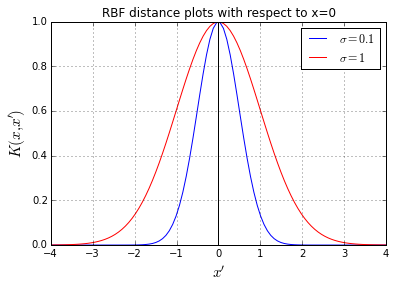

In [3]:
x = np.linspace(-4, 4, num=100)
zero = np.matrix([[0]])
y1 = [rbf_kernel(zero, np.matrix([[xi]]), 0.5)[0][0] for xi in x]
y2 = [rbf_kernel(zero, np.matrix([[xi]]), 1)[0][0] for xi in x]
plt.plot(x, y1, 'b-', label="$\sigma=0.1$")
plt.plot(x, y2, 'r-', label="$\sigma=1$")
plt.plot((0, 0), (0, 1), 'k-')
plt.xlabel('$x\'$', fontsize=15)
plt.ylabel('$K(x,x\')$', fontsize=15)
plt.title('RBF distance plots with respect to x=0')
plt.grid()
plt.legend(loc=1)
plt.show()

Cholesky decomposition requires your matrix to be positive definite. If your matrix supposed to be positive definite, you can add a small jitter (e.g. 10−5) to the diagonal of the matrix until it becomes a positive definite matrix. If your derivation is
wrong, then don’t bother it.
http://home.in.tum.de/~xiaoh/emmemo.pdf

### Sampling from prior:

The modelling of the covariance function as a kernel implies a distribution over functions because it's possible to sample from this distribution of functions at any number of points. To sample from a prior with mean $m(\mathbf{x})=0$ and kernel $K(\mathbf{x},\mathbf{x})$ we can pick a number of input points $X_*$ and create the corresponding covariance matrix defined by  $K(X_*,X_*)$ ($=K_{**}$). It is possible to then generate a random Guassian vector $f(X_*)=\mathbf{y}_*$ by sampling from $\mathcal{N}(0,K_{**})$

#### Sample from multivariate Gaussian distribution

https://en.wikipedia.org/wiki/Multivariate_normal_distribution#Drawing_values_from_the_distribution

It is possible to sample from the multivariate $\mathbf{y}_* \sim \mathcal{N}(0,K_{**})$ with the help of the Cholesky decomposition $K_{**} = L * L^T$. To see this remember that the covariance of $B = LA$ is $L\Sigma_{A}L^T$. So we can write $K_{**} =  L * L^T = LIL^T$, with $I$ the identity matrix, and sample from $\mathbf{y}_* \sim L\mathcal{N}(0,I)$

We illustrate this below by sampling at discrite points from $\mathcal{N}(0,I)$ with np.random.normal and taking the dot product of this with $L$. We sample 5 functions in total. Note that each of them is quite smooth since the RBF kernel function acts as a smoothness prior.

https://en.wikipedia.org/wiki/Covariance_function


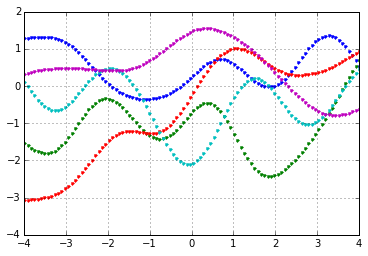

In [9]:
nb_of_samples = 100 # number of test points.
Xtest = np.matrix(np.linspace(-4, 4, nb_of_samples)).T

K = rbf_kernel(Xtest, Xtest) # Kernel at test points.

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K + 1e-14 * np.eye(nb_of_samples))
f_prior = L.dot(np.random.normal(size=(nb_of_samples,5)))
plt.plot(Xtest, f_prior, '.')
plt.grid()
plt.show()

## Sample from posterior
Observed data: $\mathcal{D} = \{ (\mathbf{x}_i, y_i), i = 1 ... n \}$ with $y_i = f(\mathbf{x}_i)$

$$p(f \mid \mathcal{D}) = \frac{p(\mathcal{D} \mid f)p(f)}{p(\mathcal{D})}$$


$$
\left[\begin{array}{c} y \\ y_{*} \end{array}\right]
\sim
\mathcal{N} \left(
\left[\begin{array}{c} \mu \\ \mu_{*} \end{array}\right]
\left[ \begin{array}{cc}
K & K_{*} \\
K_{*}^T & K_{**}
\end{array} \right]
\right)
$$

With $K=\kappa(X,X)$, $K_{*}=\kappa(X,X_{*})$, $K_{**}=\kappa(X,X_{**})$

Training set : $X$, test set: $X_*$

$$\begin{split}
p(f_* \mid X_*, X, y) & =  \mathcal{N}(\mu_*, \Sigma_*) \\
\mu_* & =  \mu(X_*) + K_*^T K^{-1} (f - \mu(X)) \\
\Sigma_* & =  K_{**} - K_*^T K^{-1}K_*
\end{split}$$

In [5]:

""" This is code for simple GP regression. It assumes a zero mean GP Prior """

np.random.seed(seed=1)

# This is the true unknown function we are trying to approximate
f = lambda x: (np.sin(0.9*x)).flatten()
#f = lambda x: (0.25*(x**2)).flatten()




N = 10       # number of training points.
n = 50         # number of test points.
s = 0.00005    # noise variance.

# Sample some input points and noisy versions of the function evaluated at
# these points. 
X = np.random.uniform(-5, 5, size=(N,1))
y = f(X) + s*np.random.randn(N)

K = kernel(X, X)
L = np.linalg.cholesky(K + s*np.eye(N))

# points we're going to make predictions at.
Xtest = np.linspace(-5, 5, n).reshape(-1,1)

# compute the mean at our test points.
Lk = np.linalg.solve(L, kernel(X, Xtest))
mu = np.dot(Lk.T, np.linalg.solve(L, y))

# compute the variance at our test points.
K_ = kernel(Xtest, Xtest)
s2 = np.diag(K_) - np.sum(Lk**2, axis=0)
s = np.sqrt(s2)

NameError: name 'kernel' is not defined

In [ ]:
np.random.seed(seed=1)
# PLOTS:
pl.figure(1)
pl.clf()
pl.plot(X, y, 'r+', ms=20)
pl.plot(Xtest, f(Xtest), 'b-')
pl.gca().fill_between(Xtest.flat, mu-3*s, mu+3*s, color="#dddddd")
pl.plot(Xtest, mu, 'r--', lw=2)
pl.savefig('predictive.png', bbox_inches='tight')
pl.title('Mean predictions plus 3 st.deviations')
pl.axis([-5, 5, -3, 3])
print('fig 1 created')

# draw samples from the prior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n))
f_prior = np.dot(L, np.random.normal(size=(n,10)))
pl.figure(2)
pl.clf()
pl.plot(Xtest, f_prior)
pl.title('Ten samples from the GP prior')
pl.axis([-5, 5, -3, 3])
pl.savefig('prior.png', bbox_inches='tight')
print('fig 2 created')

# draw samples from the posterior at our test points.
L = np.linalg.cholesky(K_ + 1e-6*np.eye(n) - np.dot(Lk.T, Lk))
f_post = mu.reshape(-1,1) + np.dot(L, np.random.normal(size=(n,10)))
pl.figure(3)
pl.clf()
pl.plot(Xtest, f_post)
pl.title('Ten samples from the GP posterior')
pl.axis([-5, 5, -3, 3])
pl.savefig('post.png', bbox_inches='tight')
print('fig 3 created')

pl.show()